# Exploratory Analysis of Titanic data and using KNN to predict survival
## Objective
The objective of this project is to perform exploratory analysis on the titanic passenger survival dataset (available here: https://www.kaggle.com/c/titanic/data) to understand how passengers features influenced survival. This will be completed using a combination of descriptive statistics, visualizations, and feature engineering. The data will be cleaned and used as a data source for KNN classification, with the goal of predicting passenger survival. Exploratory analysis performed on training data set (train.csv), and tested on test data (test.csv)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(style='ggplot')
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Load datasets into pandas dataframes
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# Initial overview of test data
test_data.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [4]:
# Get descriptions of data attributes
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [5]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

From this first glance of the data, we know the following:
- There are 891 records in the dataset, spanning 12 attributes
- The Age attribute is missin 177 records - this is a significant amount. If this attribute is included in the analysis / classification, it will need to be cleaned
- The Cabin attribute is missing 687 record (77%). Embarked is missing 2 records (in the test data). We will deal with missing data after further exploratory analysis

In [6]:
train_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Reuchlin, Jonkheer. John George",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


# Initial Analysis #
Based on the above descriptive statistics (and some general contextual knowledge about the Titanic disaster), an explanation of which original attributes will be included or excluded and why can be found below:
1. **`PassengerID`**: After a first glance, it is clear that this attribute is simply an index. All passengers have unique values from 1 to 891 (total number of passengers). We could use it as the dataframe index, but it doesn't add any value to re-index. It will not be needed for further analysis - I will drop it from the dataframe

2. **`Survived`**: This must be included. It is a binary value indicating whether or not the passenger survived (1) or died (0). We cannot predict survival without this outcome data

3. **`Pclass`**: Pclass represents Passenger Class, a proxy for socio-economic status. My hypothesis is that wealthier individuals may have been favored in evacuation situations or have been in Cabin positions that were easier to evacuate (fewer people). I will include it in the analysis to test this hypothesis. The attribute has three possible values: 1, 2, or 3

4. **`Name`**: Name of the passengers will be included in the analysis. We can see that the names given include titles (Mr., Mrs., Miss, Etc.) that may be useful in feature engineering. For example, doctors, military men, nobles may have had duties or preferential treatment that had direct impacts on survivablility

5. **`Sex`**: The standard evacuation protocol at the time tended towards "women and children first." As such, I suspect that both Sex and Age will be correlated to survival. I will include Sex in further analysis to test this hypothesis. In the given data, Sex has two possible values: "male" and "female"

6. **`Age`**: Passenger age will be included for reasons described above. This attribute also has 177 missing values which I'll need to work on. From the descriptive statistics table, we can see that the youngest passenger aboard Titanic was a baby of age `0.42`, and the oldest was `80`years old. The average age was `29.7` years. Depending on the distribution of the ages, I may be able to use the average or median values for passengers with missing Age data

7. **`SibSp`** (Number of Sibling/Spouse aboard) and **`Parch`** (Number of Parent/Child aboard) attributes combined give us an idea of the family size. I suspect these attributes will have a meaninful impact on survivability. Families may have been more likely to evacuate first / together. I will keep these two variables for further analysis to answer these questions. From the table above, we can see that `SibSp` has values from `0` (passengers traveling solo) to `8`, and `Parch` - from `0` to `6`.

8. **`Ticket`** and **`Fare`** represent ticket number and ticket fare: 
    - Ticket number would probably be the same for all members of a family and this fact might potentially be used to group passengers traveling together as a family. However, this might not be true 100% of the time if the family was buying multiple tickets. Additionally, the data is split into training and test datasets, and members of the same family might end up in different datasets. For purposes of the analysis, I think Ticket Number will be redundant with `SibSp` and `Parch`, as they contain all the summary information about families that we might need for the analysis. Hence, I am dropping ticket as an attribute
    - The `Fare` data should reflect the class the passenger was traveling in. A first class ticket is more expensive than a 3rd class ticket. If the ticket was purchased for several family members, the fare of the ticket in the dataset would be the same for every family member who was traveling under this ticket. We also don't know if any of the tickets were purchased with a discount or had a special price - we have no information on this. To further complicate matters, there may also be a correlation based on trip distance (where passengers `Embarked` from). Given the lack of information surrounding `Fare`, I will examine the relationship between `Fare` and `Pclass`, and drop `Fare` if they are redundant  

9. **`Cabin`** is the cabin number where the passenger stayed. The column has 687 missing values (out of 891). It is a categorical attribute, which for the purpose of our analysis we decided to drop for multiple reasons:
    - Too many missing values
    - Some of the value are hard to interpret. For example, one of the record displays cabin number as `C23 C25 C27`. Does this mean that the family was occupying three cabins and there was no information about what members of a family stayed in what exactly cabin? If this true, then any results of using this attribute for analysis would be difficult to interpret
    
10. **`Embarked`** is the last attribute in the dataset. It shows the port in which a passenger has embarked. The attribute has three possible values: `C` - Cherbourg, `S` - Southampton and `Q` - Queenstown. There seems to be very little correlation between the port of embarkation and the events that unfolded several days later, but I will keep this attribute and test the hypothesis later

# Summary #
To summarize, I decided to drop the following attributes from the dataframe:
- `PassengerId`
- `Ticket`
- `Fare`
- `Cabin`

In [7]:
pd.pivot_table(train_data, values = 'Fare', index = 'Pclass', aggfunc = np.mean)

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


In [8]:
pd.pivot_table(train_data, values = 'Fare', index = 'Pclass', aggfunc = np.median)

,Fare
Pclass,
1,60.2875
2,14.2500
3,8.0500


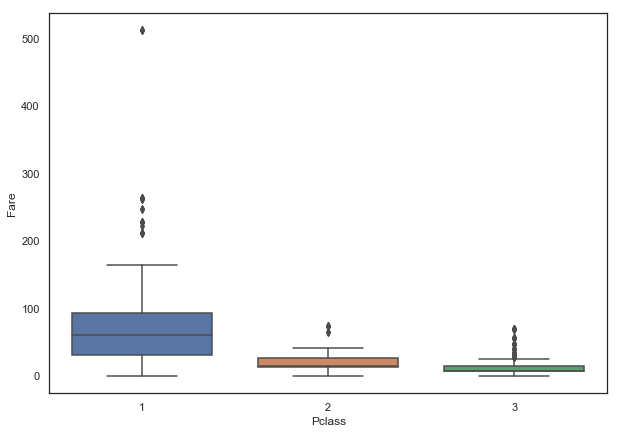

In [9]:
# Visualizing relationshp between Pclass and Fare
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style("white")
sns.boxplot(x = train_data.Pclass, y = train_data.Fare, width = .75)

The above analysis between `Fare` and `Pclass` indicate that they are heavily related on average. The boxplot indicates that average ticket price decreases across each Pclass, with `Pclass` = 1 having the highest average `Fare` and `Pclass` = 3 having the lowest average ticket price. Additionally, we can see that both median and average Fares decrease across Pclass 1 to 0. For these reasons and those described previously, I am concluding that `Fare` can be dropped and I will use `Pclass` as a proxy going forward.  

In [10]:
# Dropping attributes
train_data.drop(['PassengerId','Ticket', 'Fare','Cabin'],axis=1, inplace=True)
train_data.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,C


# Exploring Gender and Age Vs. Survivability
I will start the analysis by visualizing Sex and Age data and exploring their connection to passenger survival

In [11]:
# Survivors by Gender
survivor_gender = pd.crosstab(train_data['Sex'],train_data['Survived'])
survivor_gender

Survived,0,1
Sex,,
female,81,233
male,468,109


In [17]:
# Percentage of passengers survived, female vs male
(train_data[['Sex','Survived']].groupby(['Sex']).mean()*100).round(2)

,Survived
Sex,
female,74.20
male,18.89


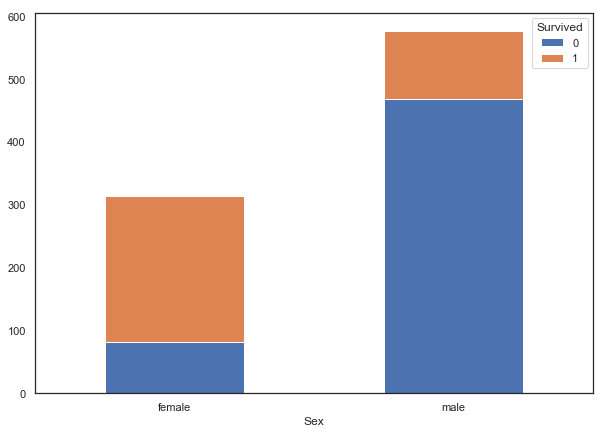

In [13]:
survivor_gender.plot(kind='bar', stacked=True, rot = 0, figsize=(10, 7))

**Conclusion:** As the results above demonstrate, female passengers indeed had much higher chance of survival, 74% for female vs 18.9% for male passengers.

Let's analyze the impact of the class of cabin. There were 3 cabin classes - `1`, `2` and `3`, reflected by the attribute `Pclass`.

In [18]:
# Survivors by Class (absolute numbers)
survivors_class = pd.crosstab(train_data['Survived'],train_data['Pclass'])
survivors_class

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [35]:
# Survivors by Class (relative %)
pd.crosstab(train_data['Survived'],train_data['Pclass']).apply(lambda x: x/x.sum(), axis = 0)

Pclass,1,2,3
Survived,,,
0,0.37037,0.527174,0.757637
1,0.62963,0.472826,0.242363


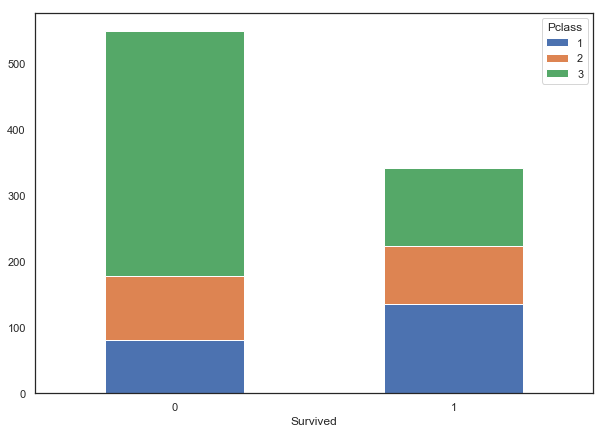

In [25]:
survivors_class.plot(kind='bar', stacked=True, rot = 0, figsize=(10, 7));

In [29]:
# Gender by Class
gender_class = pd.crosstab(train_data['Pclass'],train_data['Sex']).apply(lambda r: r/r.sum(), axis = 1)
gender_class

Sex,female,male
Pclass,,
1,0.435185,0.564815
2,0.413043,0.586957
3,0.293279,0.706721


In [ ]:
survivor_age